In [ ]:
import numpy as np
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
import toml
import imputegap
import os

# Extract multiple variables for a single station
custom_data = clim[1][["tas",'tasmin']].resample(time="1D").mean().to_array().mean("station_id")

ts = TimeSeries()
ts.data = custom_data.copy().values
ts.n_series, ts.seq_len = ts.data.shape  # (4, time)

# Optional: normalize
ts.normalize(normalizer="z_score")

# Contaminate the data (MCAR)
ts_m = ts.Contamination.mcar(ts.data, rate_dataset=0.05, rate_series=0.05)

../../usecase/conf
False


ValueError: No dataset loaded. Call `load()` first.

In [6]:
import numpy as np
import pandas as pd
import hvplot.pandas
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries

# -----------------------------
# 1️⃣ Load data
# -----------------------------
custom_data = pd.read_csv(
    '../outputs/hyras_surface_LAT_52.89_LON_13.25_19890101_20141231.csv'
)
# Pivot: rows=time, columns=variable
data = custom_data.pivot_table(columns='variable', index='time', values='value')

# -----------------------------
# 2️⃣ Prepare TimeSeries object
# -----------------------------
ts = TimeSeries()
ts.data = data.values.T                  # shape: (n_series, seq_len)
ts.n_series, ts.seq_len = ts.data.shape

# Optional normalization (recommended for CDRec)
ts.normalize(normalizer="z_score")

# -----------------------------
# 3️⃣ Apply MCAR contamination per row
# -----------------------------
ts_m_list = []
for i in range(ts.n_series):
    row = ts.data[i:i+1]  # shape (1, seq_len)
    row_m = TimeSeries.Contamination.mcar(
        row,
        rate_dataset=0.01,
        rate_series=0.01,
    )
    ts_m_list.append(row_m[0])
ts_m = np.vstack(ts_m_list)

# -----------------------------
# 4️⃣ Run CDRec imputer (BRITS-like)
# -----------------------------
# imputer = Imputation.MatrixCompletion.SoftImpute(ts_m)
imputer = Imputation.DeepLearning.BRITS(ts_m)

imputer.epochs = 500          # increase iterations for better recovery
imputer.impute()
recovered = imputer.recov_data

# -----------------------------
# 5️⃣ Denormalize manually
# -----------------------------
def denormalize(data, ts):
    """Denormalize z-score normalized TimeSeries data"""
    return data * ts.data.std(axis=0) + ts.data.mean(axis=0)

ts_denorm = denormalize(ts.data, ts)
recovered_denorm = denormalize(recovered, ts)

# -----------------------------
# 6️⃣ Prepare missing mask for plotting
# -----------------------------
series_idx = 3  # pick which series to visualize
missing_mask = np.isnan(ts_m[series_idx])

df = pd.DataFrame({
    "original_at_missing": np.where(missing_mask, ts_denorm[series_idx], np.nan),
    "recovered_at_missing": np.where(missing_mask, recovered_denorm[series_idx], np.nan),
    "original_full": ts_denorm[series_idx],
})

# -----------------------------
# 7️⃣ Plot
# -----------------------------
df.hvplot(title=f"Imputation for Series {series_idx}", height=300)




> logs: normalization (z_score) of the data - runtime: 0.0002 seconds

(CONT) missigness pattern: MCAR
	selected series: 1
	percentage of contaminated series: 1.0%
	rate of missing data per series: 1.0%
	block size: 10
	security offset: [0-949]
	seed value: 42

(CONT) missigness pattern: MCAR
	selected series: 1
	percentage of contaminated series: 1.0%
	rate of missing data per series: 1.0%
	block size: 10
	security offset: [0-949]
	seed value: 42

(CONT) missigness pattern: MCAR
	selected series: 1
	percentage of contaminated series: 1.0%
	rate of missing data per series: 1.0%
	block size: 10
	security offset: [0-949]
	seed value: 42

(CONT) missigness pattern: MCAR
	selected series: 1
	percentage of contaminated series: 1.0%
	rate of missing data per series: 1.0%
	block size: 10
	security offset: [0-949]
	seed value: 42

(SYS) Inner files loaded :  /home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/imputegap/env/default_values.toml 

(Batch-Size) Computed batch size: 2

/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/imputegap/wrapper/AlgoPython/BRITS/runnerBRITS.py:72: ResourceWarning: unclosed file <_io.TextIOWrapper name='./imputegap_assets/models/brits.tmp' mode='w' encoding='UTF-8'>
  prepare_dat(cont_data_matrix, "./imputegap_assets/models/brits.tmp", mask_train, mask_test, mask_valid)
/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/imputegap/wrapper/AlgoPython/BRITS/data_loader.py:22: ResourceWarning: unclosed file <_io.TextIOWrapper name='./imputegap_assets/models/brits.tmp' mode='r' encoding='UTF-8'>
  self.content = open(filename).readlines()


(IMPUTATION) BRITS_I_UNIV
	Matrix: 4, 9496
	epoch: 5
	batch_size: 2
	nbr_features: 1
	seq_length: 9496
	hidden_layers: 64
	num_workers: 0
	tr_ratio: 0.9

 Progress epoch 0, 50.00%, batch 0 [torch.Size([2, 9496, 1])], average loss 0.6059547066688538
 Progress epoch 0, 100.00%, batch 1 [torch.Size([2, 9496, 1])], average loss 0.67275071144104
 Progress epoch 1, 50.00%, batch 0 [torch.Size([2, 9496, 1])], average loss 0.6009618043899536
 Progress epoch 1, 100.00%, batch 1 [torch.Size([2, 9496, 1])], average loss 0.6685494184494019
 Progress epoch 2, 50.00%, batch 0 [torch.Size([2, 9496, 1])], average loss 0.5963737964630127
 Progress epoch 2, 100.00%, batch 1 [torch.Size([2, 9496, 1])], average loss 0.6645755767822266
 Progress epoch 3, 50.00%, batch 0 [torch.Size([2, 9496, 1])], average loss 0.5918430089950562
 Progress epoch 3, 100.00%, batch 1 [torch.Size([2, 9496, 1])], average loss 0.6606096029281616
 Progress epoch 4, 50.00%, batch 0 [torch.Size([2, 9496, 1])], average loss 0.587196

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [5]:
data

variable,pr,rsds,tasmax,tasmin
time,,,,
1989-01-01,1.3,7.342059,7.4,-0.5
1989-01-02,0.0,12.163617,6.5,3.2
1989-01-03,0.0,20.013840,3.2,-1.5
1989-01-04,0.3,37.562168,3.2,-3.1
1989-01-05,0.1,12.470503,5.2,2.0
...,...,...,...,...
2014-12-27,0.0,32.680847,-2.5,-6.9
2014-12-28,5.2,33.960476,-1.1,-9.0
2014-12-29,0.0,36.823166,-2.2,-7.9


In [2]:
import climdata
from climdata import ClimData
import json
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [8.0, 50.0],
            [10.0, 50.0],
            [10.0, 55.0],
            [8.0, 55.0],
            [8.0, 50.0]
          ]
        ]
      }
    }
  ]
}

overrides = [
    "dataset=cmip",  # Select the MSWX dataset for extraction
    f"aoi='{json.dumps(geojson)}'",  # Set AOI as the point defined above
    f"time_range.start_date=2004-01-01",  # Start date of extraction
    f"time_range.end_date=2014-12-31",    # End date of extraction
    "variables=[tasmin,tasmax,pr]",       # Variables to extract: min/max temperature & precipitation
    "data_dir=/beegfs/muduchuru/data",    # Local directory to store downloaded/intermediate files
    # Optional Google service account if needed for MSWX access
    # "dsinfo.mswx.params.google_service_account=./.climdata_conf/service.json",
    "index=tn10p",  # Extreme climate index to calculate
]

extractor = ClimData(overrides=overrides)
ds = extractor.extract()

# climdata.impute.impute_xarray.Imputer(ds)

/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  cat = self.__class__({'esmcat': self.esmcat.dict(), 'df': esmcat_results})
/home/muduchuru/miniforge3/envs/sdba/lib/python3.10/site-packages/intake_esm/core.py:475: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pyd

In [3]:
imputer = climdata.impute.impute_xarray.Imputer(ds, method='BRITS')
ds_recov = imputer.impute()

No missing data found. Imputation not required.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
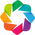

:Overlay
   .Scatter.I :Scatter   [original]   (recovered)
   .Curve.I   :Curve   [x]   (y)

In [7]:
import holoviews as hv
hv.extension('bokeh')

series_idx = 2
missing_mask = np.isnan(ts_m[series_idx])

# Prepare DataFrame for scatter: only include missing points
df_scatter = pd.DataFrame({
    "original": ts_denorm[series_idx][missing_mask],
    "recovered": recovered_denorm[series_idx][missing_mask]
})


# Scatter of recovered vs original
scatter = df_scatter.hvplot.scatter(x="original", y="recovered", alpha=0.7)

# Create y=x line
min_val = df_scatter["original"].min()
max_val = df_scatter["original"].max()
line = hv.Curve([(min_val, min_val), (max_val, max_val)])

# Overlay
(scatter * line.opts(color='red', line_width=2, alpha=0.5))
# scatter


In [ ]:
plt.scatter()

AttributeError: 'TimeSeries' object has no attribute 'mean'

In [44]:
df.mean()

original_at_missing     1.746071e-01
recovered_at_missing    0.000000e+00
original_full           2.738612e-16
dtype: float64

In [12]:
df.missing.dropna()

Series([], Name: missing, dtype: float64)

In [7]:
custom_data.pivot_table(columns='variable', index='time', values='value').values

array([[ 0.14759682, 18.82771   , -0.86761475, -2.2676392 ],
       [ 0.42055786, 10.754679  ,  0.8147888 , -1.3565979 ],
       [ 0.34101963, 16.703186  ,  0.5118103 , -0.75808716],
       ...,
       [ 0.38728255,  6.5801907 ,  7.9005127 ,  6.724945  ],
       [ 0.6813643 , 24.407694  ,  6.708557  ,  5.060028  ],
       [ 1.4656599 , 20.525047  ,  6.541748  ,  4.2891235 ]])

In [ ]:
import os
import tempfile
import numpy as np
import pandas as pd
import hvplot.pandas
import xarray as xr

# --- 5️⃣ Run BRITS ---
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()  # will use 5 epochs

# --- 6️⃣ Recovered data ---
recovered = imputer.recov_data

# --- 7️⃣ Interactive plotting with hvPlot ---
df = pd.DataFrame({
    "original": ts.data[0],
    # Only show original values where missing
    "missing": np.where(np.isnan(ts_m[0]), ts.data[0], np.nan),
    # Only show recovered values where missing
    "recovered": np.where(np.isnan(ts_m[0]), recovered[0], np.nan)
})

df.hvplot(title="MPIN Imputation", height=300)


ERROR: Rank choosen to high for the number of series: 3 >= 2.
	Rank reduced to 2.

(IMPUTATION) CDRec
	Matrix: 2, 9496
	truncation rank: 2
	epsilon: 1e-06
	iterations: 100

> logs: imputation cdrec - Execution Time: 0.3654 seconds.


:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [32]:
ts.plot(input_data=ts.data, incomp_data=ts_m, recov_data=imputer.recov_data, nbr_series=9, subplot=True, algorithm=imputer.algorithm, save_path="./imputegap_assets/imputation")


plots saved in: ./imputegap_assets/imputation/25_11_26_13_36_16_mpin_plot.jpg


'./imputegap_assets/imputation/25_11_26_13_36_16_mpin_plot.jpg'

In [35]:
imputer.score(ts.data, imputer.recov_data)
ts.print_results(imputer.metrics)


Results :
RMSE                 = 0.29017749830807504
MAE                  = 0.23852259275095283
MI                   = 1.0073774172207155
CORRELATION          = 0.9553585676700678


In [36]:
ts.data

array([[-0.6118232 , -0.67718905, -1.2001158 , ..., -1.87992058,
        -1.44850601, -0.93865242],
       [-0.8332815 , -0.28144307, -0.98242702, ..., -1.93695836,
        -1.38511993, -0.62447777]])

In [ ]:
df = pd.DataFrame({
    "original": ts.data[0],
    "missing": np.where(np.isnan(ts_m[0]), np.nan, ts.data[0]),
    "recovered": recovered[0]
})
df.hvplot(title="BRITS Imputation", height=300)

470

In [ ]:
import hvplot.xarray
(ts.data.to_pandas().T.hvplot() + imputer.recov_data.hvplot() + ts_m.hvplot())

Init signature: Imputation.DeepLearning.BRITS(incomp_data)
Docstring:     
BRITS class to impute missing values using Bidirectional Recurrent Imputation for Time Series

Methods
-------
impute(self, user_def=True, params=None):
    Perform imputation using the BRITS algorithm.
Init docstring:
Initialize the BaseImputer with an infected time series matrix.

Parameters
----------
incomp_data : numpy.ndarray
    Matrix used during the imputation of the time series.
File:           ~/miniforge3/envs/sdba/lib/python3.10/site-packages/imputegap/recovery/imputation.py
Type:           type
Subclasses:     